In [1]:
import pandas as pd
import geopandas as gpd

#I always do this because I always wanna be able to see all of my columns
#and as many rows as I want. But be careful because you could accidentally 
#ask the code to show you like 2 million rows, crushing your machine's memory.
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

/var/folders/2g/mqj0d6v95vbfcqgf7kpgrsrc0000gr/T/ipykernel_61842/3024890906.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Make a beat-specific geographic crosswalk
It can be extremely helpful to have a single document that tells you a bunch of specifics about a single location. For example, it's super helpful to know which neighborhood and Census tract each area school is in so you can quickly pull Census data related to each school. 

## Download the data we need
If you're following along at NICAR2024, you've already got the Census tracts and blocks for Maryland saved in the data folder of this project. 

If you're trying to replicate this on your own computer or for your own area, you're going to need to download those datasets.

Find the shapes you're after here: https://www2.census.gov/geo/tiger/TIGER2022/. Copy the link to the zip file. In a lot of cases the shapefiles are broken out by state. Familiarize yourself with the state FIPS codes.

Here are some confusing filenames and what's in them:
- PLACE = cities, towns, etc
- SCSD and UNSD = school districts
- TABBLOCK20 = Census blocks
- BG = Census block group

In [2]:
#If you're working from home, run this line
#tracts_shp = gpd.read_file('https://www2.census.gov/geo/tiger/TIGER2022/TRACT/tl_2022_24_tract.zip')

#If you're in the NICAR class, run this line
tracts_shp = gpd.read_file('../data/md-census-tracts/tl_2022_24_tract.shp')

## Filter just the data you need
Did you see how long it took to download those files? That's because they big. If we can get the size down so we're just working with the features we need, all of our analysis will go alot faster.

There are two types of filters we can do here:
- Attribute table filter: filter by the data behind our shapes
- Spatial filter: filter by where the features are are geographically

### Attribute filter first
Let's look at what data are available to us in the attribute table of the tracts. If you're familiar with the Pandas Python library, this should look super familiar to you.

In [3]:
tracts_shp.head(2)

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,24,033,807304,24033807304,8073.04,Census Tract 8073.04,G5020,S,1776714,0,+39.0249780,-076.9594342,"POLYGON ((-76.97171 39.01858, -76.97164 39.018..."
1,24,033,807305,24033807305,8073.05,Census Tract 8073.05,G5020,S,3030479,4428,+39.0121779,-076.9635510,"POLYGON ((-76.97728 39.01095, -76.97714 39.011..."


In fact, geopandas can do pretty much everything regular pandas can do. Let's filter these tracts to just Baltimore County tracts. 

In [4]:
bmore_tracts = tracts_shp.loc[tracts_shp['COUNTYFP'] == '510']
print('All MD tracts:',len(tracts_shp))
print('Bmore tracts:',len(bmore_tracts))

All MD tracts: 1475
Bmore tracts: 199


We can used the built-in `plot` to see these shapes.

<Axes: >

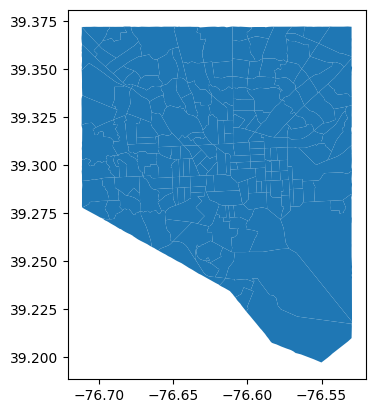

In [5]:
bmore_tracts.plot()

If you want a sexier visualization library, checkout [plotly](https://plotly.com/python/).

### Now the spatial filter
Geopandas can do most everything regular pandas can do AND MORE! For instance, we can ask geopandas to look at a bunch of Maryland schools and just return the ones that are in those Baltmore tracts we just created.

In [6]:
md_schools = gpd.read_file('../data/md-public-schools/EDGE_GEOCODE_PUBLICSCH_2223_Maryland.shp')
bmore_schools = md_schools.sjoin(bmore_tracts, how='left')

In [7]:
print(len(md_schools))
print(len(bmore_schools))
bmore_schools.head(2)

1425
1425


,NCESSCH,LEAID,NAME_left,OPSTFIPS,STREET,CITY,STATE,ZIP,STFIP,CNTY,NMCNTY,LOCALE,LAT,LON,CBSA,NMCBSA,CBSATYPE,CSA,NMCSA,NECTA,NMNECTA,CD,SLDL,SLDU,SCHOOLYEAR,geometry,index_right,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME_right,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON
0,110008700213,1100087,Maya Angelou Academy at New Beginnings formerl...,11,8400 River Rd,Laurel,MD,20724,24,24003,Anne Arundel County,41,39.101153,-76.787327,12580,"Baltimore-Columbia-Towson, MD",1,548,"Washington-Baltimore-Arlington, DC-MD-VA-WV-PA",N,N,2403,24021,24021,2022-2023,POINT (-76.78733 39.10115),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,240002701669,2400027,The Seed School of Maryland,24,200 Font Hill Avenue,Baltimore,MD,21223,24,24510,Baltimore city,11,39.284040,-76.664092,12580,"Baltimore-Columbia-Towson, MD",1,548,"Washington-Baltimore-Arlington, DC-MD-VA-WV-PA",N,N,2407,2444A,24044,2022-2023,POINT (-76.66409 39.28404),1130.0,24,510,200600,24510200600,2006,Census Tract 2006,G5020,S,1770698.0,30330.0,+39.2840120,-076.6637324


As you see, there are still the same number or schools. That's because we haven't technically filtered them. We've just add the `bmore_tracts` data to the `md_schools` shapes. But that ALLOWS us to filter now because a ton of these schools aren't going to have tract info. So we can just filter out the ones without tract info.

In [8]:
bmore_schools = bmore_schools.loc[~(bmore_schools['TRACTCE'].isna())]
print(len(bmore_schools))
display(bmore_schools.head(2))

157


,NCESSCH,LEAID,NAME_left,OPSTFIPS,STREET,CITY,STATE,ZIP,STFIP,CNTY,NMCNTY,LOCALE,LAT,LON,CBSA,NMCBSA,CBSATYPE,CSA,NMCSA,NECTA,NMNECTA,CD,SLDL,SLDU,SCHOOLYEAR,geometry,index_right,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME_right,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON
1,240002701669,2400027,The Seed School of Maryland,24,200 Font Hill Avenue,Baltimore,MD,21223,24,24510,Baltimore city,11,39.28404,-76.664092,12580,"Baltimore-Columbia-Towson, MD",1,548,"Washington-Baltimore-Arlington, DC-MD-VA-WV-PA",N,N,2407,2444A,24044,2022-2023,POINT (-76.66409 39.28404),1130.0,24,510,200600,24510200600,2006,Census Tract 2006,G5020,S,1770698.0,30330.0,+39.2840120,-076.6637324
150,240009000143,2400090,Abbottston Elementary,24,1300 Gorsuch Avenue,Baltimore,MD,21218,24,24510,Baltimore city,11,39.32510,-76.599495,12580,"Baltimore-Columbia-Towson, MD",1,548,"Washington-Baltimore-Arlington, DC-MD-VA-WV-PA",N,N,2407,24043,24043,2022-2023,POINT (-76.59950 39.32510),976.0,24,510,090500,24510090500,905,Census Tract 905,G5020,S,741595.0,0.0,+39.3249389,-076.6012005


## Drop columns we don't need
Holy moly, that's a lot of columns. Let's get rid of some of the duplicated ones and the ones we don't need. And maybe rename some of the columns that that are a bit confusing now that we've got all this info in there.

In [9]:
bmore_schools.columns

Index(['NCESSCH', 'LEAID', 'NAME_left', 'OPSTFIPS', 'STREET', 'CITY', 'STATE',
       'ZIP', 'STFIP', 'CNTY', 'NMCNTY', 'LOCALE', 'LAT', 'LON', 'CBSA',
       'NMCBSA', 'CBSATYPE', 'CSA', 'NMCSA', 'NECTA', 'NMNECTA', 'CD', 'SLDL',
       'SLDU', 'SCHOOLYEAR', 'geometry', 'index_right', 'STATEFP', 'COUNTYFP',
       'TRACTCE', 'GEOID', 'NAME_right', 'NAMELSAD', 'MTFCC', 'FUNCSTAT',
       'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON'],
      dtype='object')

In [10]:
keep_cols = ['NCESSCH', 'LEAID', 'NAME_left', 'OPSTFIPS', 'STREET', 'CITY', 'STATE',
             'ZIP', 'STFIP', 'CNTY', 'NMCNTY', 'LOCALE', 'LAT', 'LON', 'CBSA',
             'NMCBSA', 'CBSATYPE', 'CSA', 'NMCSA', 'NECTA', 'NMNECTA', 'CD', 'SLDL',
             'SLDU', 'SCHOOLYEAR', 'geometry',
             'TRACTCE', 'GEOID']
rename_cols = {'GEOID':'TRACT_GEOID'}
bmore_schools = bmore_schools[keep_cols].rename(columns=rename_cols)

## Bring in more data
You may ask, why didn't we just add more data in that who section that was about adding data, Allie. GEEZ.

It's actually pretty important to drop fields that you don't need between joins to avoid errors like:

```
ValueError: 'index_left' and 'index_right' cannot be names in the frames being joined
```

In [11]:
bmore_hoods = gpd.read_file('../data/bmore-neighborhoods/Neighborhood.shp')
bmore_schools_hoods = bmore_schools.sjoin(bmore_hoods,how='left')

display(bmore_schools_hoods.head(2))

/Users/alexandra.kanik/personal/nicar24/nicar24-mapping-session/env/lib/python3.9/site-packages/geopandas/geodataframe.py:2187: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4269
Right CRS: EPSG:2248

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)  # noqa: B026


,NCESSCH,LEAID,NAME_left,OPSTFIPS,STREET,CITY,STATE,ZIP,STFIP,CNTY,NMCNTY,LOCALE,LAT,LON,CBSA,NMCBSA,CBSATYPE,CSA,NMCSA,NECTA,NMNECTA,CD,SLDL,SLDU,SCHOOLYEAR,geometry,TRACTCE,TRACT_GEOID,index_right,OBJECTID,Name,Population,White,Blk_AfAm,AmInd_AkNa,Asian,NatHaw_Pac,Other_Race,TwoOrMore,Hisp_Lat,Housing,Occupied,Vacant,Shape__Are,Shape__Len
1,240002701669,2400027,The Seed School of Maryland,24,200 Font Hill Avenue,Baltimore,MD,21223,24,24510,Baltimore city,11,39.28404,-76.664092,12580,"Baltimore-Columbia-Towson, MD",1,548,"Washington-Baltimore-Arlington, DC-MD-VA-WV-PA",N,N,2407,2444A,24044,2022-2023,POINT (-76.66409 39.28404),200600,24510200600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150,240009000143,2400090,Abbottston Elementary,24,1300 Gorsuch Avenue,Baltimore,MD,21218,24,24510,Baltimore city,11,39.32510,-76.599495,12580,"Baltimore-Columbia-Towson, MD",1,548,"Washington-Baltimore-Arlington, DC-MD-VA-WV-PA",N,N,2407,24043,24043,2022-2023,POINT (-76.59950 39.32510),090500,24510090500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Oh no! The two shapefiles we're trying to sjoin are in different projections! Never fear. It's an easy fix with geopandas.

In [12]:
bmore_hoods = gpd.read_file('../data/bmore-neighborhoods/Neighborhood.shp')
bmore_hoods = bmore_hoods.to_crs(4269)

bmore_schools_hoods = bmore_schools.sjoin(bmore_hoods,how='left')
display(bmore_schools_hoods.head(2))

,NCESSCH,LEAID,NAME_left,OPSTFIPS,STREET,CITY,STATE,ZIP,STFIP,CNTY,NMCNTY,LOCALE,LAT,LON,CBSA,NMCBSA,CBSATYPE,CSA,NMCSA,NECTA,NMNECTA,CD,SLDL,SLDU,SCHOOLYEAR,geometry,TRACTCE,TRACT_GEOID,index_right,OBJECTID,Name,Population,White,Blk_AfAm,AmInd_AkNa,Asian,NatHaw_Pac,Other_Race,TwoOrMore,Hisp_Lat,Housing,Occupied,Vacant,Shape__Are,Shape__Len
1,240002701669,2400027,The Seed School of Maryland,24,200 Font Hill Avenue,Baltimore,MD,21223,24,24510,Baltimore city,11,39.28404,-76.664092,12580,"Baltimore-Columbia-Towson, MD",1,548,"Washington-Baltimore-Arlington, DC-MD-VA-WV-PA",N,N,2407,2444A,24044,2022-2023,POINT (-76.66409 39.28404),200600,24510200600,83,84,Carroll-South Hilton,1241,47,1075,4,7,0,43,65,64,574,459,115,1.308144e+07,16102.256134
150,240009000143,2400090,Abbottston Elementary,24,1300 Gorsuch Avenue,Baltimore,MD,21218,24,24510,Baltimore city,11,39.32510,-76.599495,12580,"Baltimore-Columbia-Towson, MD",1,548,"Washington-Baltimore-Arlington, DC-MD-VA-WV-PA",N,N,2407,24043,24043,2022-2023,POINT (-76.59950 39.32510),090500,24510090500,97,98,Coldstream Homestead Montebello,5638,139,5107,20,25,0,112,235,166,2790,2068,722,1.452942e+07,16794.548797


Look at all of that data! But at this point, there's no indication that those population data stats related to the neighborhoods. Let's try this join one more time, this time using suffixes.

Notice we're using just the regular pandas `.add_suffix` here instead of the geopandas sjoin parameter `rsuffix` because rsuffix will only add suffixes if there's column name overlap.

In [13]:
bmore_hoods = gpd.read_file('../data/bmore-neighborhoods/Neighborhood.shp')
bmore_hoods = bmore_hoods.add_suffix('_hoods').set_geometry('geometry_hoods')
bmore_hoods = bmore_hoods.to_crs(4269)


bmore_schools_hoods = bmore_schools.sjoin(bmore_hoods,how='left')
display(bmore_schools_hoods.head(2))

,NCESSCH,LEAID,NAME_left,OPSTFIPS,STREET,CITY,STATE,ZIP,STFIP,CNTY,NMCNTY,LOCALE,LAT,LON,CBSA,NMCBSA,CBSATYPE,CSA,NMCSA,NECTA,NMNECTA,CD,SLDL,SLDU,SCHOOLYEAR,geometry,TRACTCE,TRACT_GEOID,index_right,OBJECTID_hoods,Name_hoods,Population_hoods,White_hoods,Blk_AfAm_hoods,AmInd_AkNa_hoods,Asian_hoods,NatHaw_Pac_hoods,Other_Race_hoods,TwoOrMore_hoods,Hisp_Lat_hoods,Housing_hoods,Occupied_hoods,Vacant_hoods,Shape__Are_hoods,Shape__Len_hoods
1,240002701669,2400027,The Seed School of Maryland,24,200 Font Hill Avenue,Baltimore,MD,21223,24,24510,Baltimore city,11,39.28404,-76.664092,12580,"Baltimore-Columbia-Towson, MD",1,548,"Washington-Baltimore-Arlington, DC-MD-VA-WV-PA",N,N,2407,2444A,24044,2022-2023,POINT (-76.66409 39.28404),200600,24510200600,83,84,Carroll-South Hilton,1241,47,1075,4,7,0,43,65,64,574,459,115,1.308144e+07,16102.256134
150,240009000143,2400090,Abbottston Elementary,24,1300 Gorsuch Avenue,Baltimore,MD,21218,24,24510,Baltimore city,11,39.32510,-76.599495,12580,"Baltimore-Columbia-Towson, MD",1,548,"Washington-Baltimore-Arlington, DC-MD-VA-WV-PA",N,N,2407,24043,24043,2022-2023,POINT (-76.59950 39.32510),090500,24510090500,97,98,Coldstream Homestead Montebello,5638,139,5107,20,25,0,112,235,166,2790,2068,722,1.452942e+07,16794.548797


## Bring in some tract data
At this point, we're pretty much ready to join any Census data that we need onto this bad boi. Since we're fancy AF with our scripted analysis, let's use the Census API.

Note: I've been eye-rolled a number of times for not using a python library to interface with the Census API but whatever man. I'm old. I like what I like.

Here are the steps to using the Census API:

**1. Get an API key [here](https://api.census.gov/data/key_signup.html)**

**2. Decide [which survey](https://www.census.gov/data/developers/data-sets.html) you need (decennial, ACS, etc)**

**3. Figure out which variables, geographies and years you want to pull data for**
Using [the link above](https://www.census.gov/data/developers/data-sets.html), follow the survey dropdowns to find the survey API page. For example, if we wanted the ACS 1-year data we'd go here to learn what geographies and variables are available for it: https://www.census.gov/data/developers/data-sets/acs-1year.html. Here we learn more about the subsets of this dataset (for instance the ACS 1-year has detail tables, subject tables, data tables and comparison tables). Once we know which subset we want, scroll down to find [examples](https://api.census.gov/data/2021/acs/acs1/profile/examples.html), links to variable lists and available geographies for each subset.

**4. Construct your URL**
I like to put all of the variables I want to pull into a list and then turn that list into a string and feed it into the URL that will fetch the data for us.

```
FYI, 1-year data are usually only available for larger areas due to sampling size issues. 
```

In [14]:
MYKEY = '5f5e920f59df757178d859ae70a4cb8297cb739c'

#I like to rename my data columns cause I'll get lost otherwise!
rename_cols = {'S1903_C03_001E':'med_income_tract',
               'S1701_C03_001E':'share_pop_poverty_tract',
               'S1701_C03_002E':'share_under18_poverty_tract',
              }

var_list = ['GEO_ID','NAME']+list(rename_cols.keys())
var_str = ','.join(var_list)

year = 2022

data_url = 'https://api.census.gov/data/'+str(year)+'/acs/acs5/subject?get='+var_str+'&for=tract:*&in=state:24&key='+MYKEY
demo_tract_df = pd.read_json(data_url)
new_header = demo_tract_df.iloc[0] #grab the first row for the header
demo_tract_df = demo_tract_df[1:] #take the data less the header row
demo_tract_df.columns = new_header #set the header row as the df header
demo_tract_df.rename(columns=rename_cols, inplace=True) #heres where we actually rename

print(len(demo_tract_df))
display(demo_tract_df.head(2))

1475


,GEO_ID,NAME,med_income_tract,share_pop_poverty_tract,share_under18_poverty_tract,state,county,tract
1,1400000US24001000100,Census Tract 1; Allegany County; Maryland,56232,11.6,17.7,24,001,000100
2,1400000US24001000200,Census Tract 2; Allegany County; Maryland,66596,10.8,27.7,24,001,000200


And now all we need to do an attribute join with our existing school data, clean up our columns and export our crosswalk!

In [15]:
bmore_schools_hoods_data = bmore_schools_hoods.merge(demo_tract_df,left_on='TRACTCE',right_on='tract')
bmore_schools_hoods_data.head(2)

,NCESSCH,LEAID,NAME_left,OPSTFIPS,STREET,CITY,STATE,ZIP,STFIP,CNTY,NMCNTY,LOCALE,LAT,LON,CBSA,NMCBSA,CBSATYPE,CSA,NMCSA,NECTA,NMNECTA,CD,SLDL,SLDU,SCHOOLYEAR,geometry,TRACTCE,TRACT_GEOID,index_right,OBJECTID_hoods,Name_hoods,Population_hoods,White_hoods,Blk_AfAm_hoods,AmInd_AkNa_hoods,Asian_hoods,NatHaw_Pac_hoods,Other_Race_hoods,TwoOrMore_hoods,Hisp_Lat_hoods,Housing_hoods,Occupied_hoods,Vacant_hoods,Shape__Are_hoods,Shape__Len_hoods,GEO_ID,NAME,med_income_tract,share_pop_poverty_tract,share_under18_poverty_tract,state,county,tract
0,240002701669,2400027,The Seed School of Maryland,24,200 Font Hill Avenue,Baltimore,MD,21223,24,24510,Baltimore city,11,39.28404,-76.664092,12580,"Baltimore-Columbia-Towson, MD",1,548,"Washington-Baltimore-Arlington, DC-MD-VA-WV-PA",N,N,2407,2444A,24044,2022-2023,POINT (-76.66409 39.28404),200600,24510200600,83,84,Carroll-South Hilton,1241,47,1075,4,7,0,43,65,64,574,459,115,1.308144e+07,16102.256134,1400000US24510200600,Census Tract 2006; Baltimore city; Maryland,43869,21.7,13.8,24,510,200600
1,240009000143,2400090,Abbottston Elementary,24,1300 Gorsuch Avenue,Baltimore,MD,21218,24,24510,Baltimore city,11,39.32510,-76.599495,12580,"Baltimore-Columbia-Towson, MD",1,548,"Washington-Baltimore-Arlington, DC-MD-VA-WV-PA",N,N,2407,24043,24043,2022-2023,POINT (-76.59950 39.32510),090500,24510090500,97,98,Coldstream Homestead Montebello,5638,139,5107,20,25,0,112,235,166,2790,2068,722,1.452942e+07,16794.548797,1400000US24510090500,Census Tract 905; Baltimore city; Maryland,55500,22.5,21.8,24,510,090500


In [16]:
keep_cols = ['NCESSCH', 'LEAID', 'NAME_left', 'STREET', 'CITY', 'STATE','STFIP',
             'ZIP', 'CNTY', 'NMCNTY', 'LOCALE', 'LAT', 'LON', 'CBSA',
             'NMCBSA', 'CBSATYPE', 'CSA', 'NMCSA', 'NECTA', 'NMNECTA', 'CD', 'SLDL',
             'SLDU', 'SCHOOLYEAR', 'geometry', 'TRACTCE', 'TRACT_GEOID',
             'Name_hoods', 'Population_hoods','White_hoods', 'Blk_AfAm_hoods', 
             'AmInd_AkNa_hoods', 'Asian_hoods','NatHaw_Pac_hoods', 'Other_Race_hoods',
             'TwoOrMore_hoods','Hisp_Lat_hoods', 'Housing_hoods', 'Occupied_hoods', 'Vacant_hoods',
             'med_income_tract','share_pop_poverty_tract', 'share_under18_poverty_tract']
rename_cols = {
    'NAME_left':'school_name',
    'NMCNTY':'county',
    'CNTY':'county_fips',
    'Name_hoods':'neighborhood',
}

bmore_schools_hoods_data = bmore_schools_hoods_data[keep_cols].rename(columns=rename_cols)
bmore_schools_hoods_data.columns = [x.upper() for x in bmore_schools_hoods_data.columns]

In [17]:
bmore_schools_hoods_data.head()

,NCESSCH,LEAID,SCHOOL_NAME,STREET,CITY,STATE,STFIP,ZIP,COUNTY_FIPS,COUNTY,LOCALE,LAT,LON,CBSA,NMCBSA,CBSATYPE,CSA,NMCSA,NECTA,NMNECTA,CD,SLDL,SLDU,SCHOOLYEAR,GEOMETRY,TRACTCE,TRACT_GEOID,NEIGHBORHOOD,POPULATION_HOODS,WHITE_HOODS,BLK_AFAM_HOODS,AMIND_AKNA_HOODS,ASIAN_HOODS,NATHAW_PAC_HOODS,OTHER_RACE_HOODS,TWOORMORE_HOODS,HISP_LAT_HOODS,HOUSING_HOODS,OCCUPIED_HOODS,VACANT_HOODS,MED_INCOME_TRACT,SHARE_POP_POVERTY_TRACT,SHARE_UNDER18_POVERTY_TRACT
0,240002701669,2400027,The Seed School of Maryland,200 Font Hill Avenue,Baltimore,MD,24,21223,24510,Baltimore city,11,39.284040,-76.664092,12580,"Baltimore-Columbia-Towson, MD",1,548,"Washington-Baltimore-Arlington, DC-MD-VA-WV-PA",N,N,2407,2444A,24044,2022-2023,POINT (-76.66409 39.28404),200600,24510200600,Carroll-South Hilton,1241,47,1075,4,7,0,43,65,64,574,459,115,43869,21.7,13.8
1,240009000143,2400090,Abbottston Elementary,1300 Gorsuch Avenue,Baltimore,MD,24,21218,24510,Baltimore city,11,39.325100,-76.599495,12580,"Baltimore-Columbia-Towson, MD",1,548,"Washington-Baltimore-Arlington, DC-MD-VA-WV-PA",N,N,2407,24043,24043,2022-2023,POINT (-76.59950 39.32510),090500,24510090500,Coldstream Homestead Montebello,5638,139,5107,20,25,0,112,235,166,2790,2068,722,55500,22.5,21.8
2,240009000146,2400090,Arlington Elementary,3705 W Rogers Avenue,Baltimore,MD,24,21215,24510,Baltimore city,11,39.350220,-76.684529,12580,"Baltimore-Columbia-Towson, MD",1,548,"Washington-Baltimore-Arlington, DC-MD-VA-WV-PA",N,N,2407,24041,24041,2022-2023,POINT (-76.68453 39.35022),271801,24510271801,Arlington,2163,52,1991,6,26,2,13,73,42,1281,1050,231,20417,38.6,30.9
3,240009000147,2400090,Armistead Gardens Elementary/Middle,5001 E Eager Street,Baltimore,MD,24,21205,24510,Baltimore city,11,39.304800,-76.552700,12580,"Baltimore-Columbia-Towson, MD",1,548,"Washington-Baltimore-Arlington, DC-MD-VA-WV-PA",N,N,2403,24045,24045,2022-2023,POINT (-76.55270 39.30480),260401,24510260401,Armistead Gardens,3779,1763,158,32,41,2,1282,501,1911,1533,1402,131,40298,29.4,50.2
4,240009000148,2400090,Arundel Elementary,2400 Round Road,Baltimore,MD,24,21225,24510,Baltimore city,11,39.251987,-76.628358,12580,"Baltimore-Columbia-Towson, MD",1,548,"Washington-Baltimore-Arlington, DC-MD-VA-WV-PA",N,N,2402,24046,24046,2022-2023,POINT (-76.62836 39.25199),250207,24510250207,Cherry Hill,7647,286,6745,18,49,1,234,314,363,3375,3047,328,50125,17.6,30.1


## In conclusion
We could keep adding to this until we've got a thousand columns. There's always more data. An important step to take is talking with your team and figuring out what is most important to them. Since we've scripted this process, what's important can change and we'll be poised to act quickly.